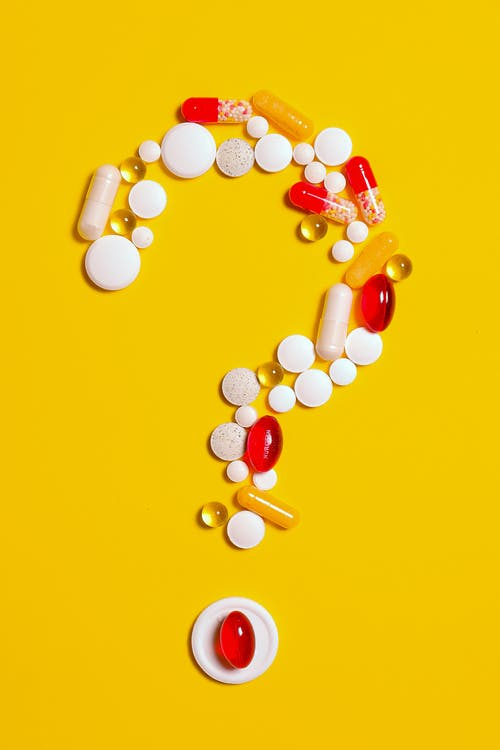

[SHVETS, Anna. Medication Pills Isolated on Yellow background.](https://www.pexels.com/photo/medication-pills-isolated-on-yellow-background-3683098/)

# **Projeto: Prevendo Mecanismos de Ação** 

##  **Desenvolvimento de medicamentos, IA e aprendizado de máquinas**

A geração de medicamentos novos é um processo complexo e custoso, mas de grande valor social. Complexo porque existem diversas etapas da descoberta e análise do gene, escolha e teste de potenciais drogas, a testagem de múltiplas drogas em animais, depois testagem em voluntários humanos (saudáveis, depois doentes) seguida de testagem em uma população massiva e enfim ser aprovada pela agência pública de saúde responsável (ROWE,2020). Apesar dos custos médios do desenvolvimento de drogas ser controversos, pode-se dizer que eles atingem centenas de milhões de dólares (WOUTERS et. al., 2020). Ainda assim, o a geração de drogas novas é fundamental para os avanços da medicina e consequente melhorias na qualidade de vida humana.

Em vista das dificuldades e riscos no desenvolvimento de drogas, as empresas biofarmaceuticas buscam novas formas de aprimorar o processo; e aqui entra o aprendizado de máquinas. Companhias da indústria farmacêutica (como Pfizer), universidades e outros centros de pesquisa vem utilizando de IA para auxiliar no processo de compreensão de doenças e desenvolvimento de drogas (FLEMING, 2018). Uma das áreas em que o aprendizado de máquina e inteligência artificial vêm se mostrando mais promissores é a de descoberta de compostos que possam ser utilizados na criação de drogas, reduzindo o tempo de pesquisa e encontrando padrões muitas vezes imperceptíveis as pessoas (MULLARD, 2017).

## **Objetivo e dados**

Na linha desses desenvolvimentos, este projeto de conclusão de curso da Terceira edição da imersão de dados 03 da Alura tem por objetivo fornecer um modelo de machine learning para auxiliar no processo de descoberta de medicamentos. Para isso se utilizou de duas base de dados: uma contendo experimentos com compostos, nos quais se avalia a resposta de um conjunto de genes (se houve intensificação ou redução nas atividades de geração de proteina a partir do material genético) e da viabilidade (sobreviência) de certos de tipos de células; e um conjunto de dados de resultado que contém informações sobre os tipos de de Mecanismos de Ação (MoA) de cada experimento, indicando como atua cada um dos compostos segundo certa dose e tempo de aplicação. Mais especificamente, o objetivo consiste em prever qual (quais) Mecanismo(s) de Ação ativados em cada experimento (considerando que são mais de 200 mecanismos de ação). 

Trata-se de projeto de aprendizado de máquina do tipo supervisionado e de classificação múltipla (na medida em que cada composto pode ativar mais de um dos MoA); inspirado no desafio publicado pelo [Laboratory Innovation Science at Harvard](https://lish.harvard.edu/) no [Kaggle](https://www.kaggle.com/c/lish-moa). 

## **Métricas**

Além de utilizarmos da métrica acurácia (total de acertos/total de previsões),em vista de manter coerência com o desafio postado no [Kaggle](https://www.kaggle.com/c/lish-moa/overview/evaluation), a avaliação do modelo se dará *também* pela métrica da 
perda em log (log loss) também conhecida como entropia binária cruzada (binary cross entopry); nosso objetivo é minimizar o valor do log (todavia, diferente do desafio do Kaggle, buscou-se reduzir a perda em log geral, e não por coluna dos dados de resultado, em vista das limitações de tempo e complexidade da tarefa):

$ \text{pontuação} = - \frac{1}{M}\sum_{m=1}^{M} \frac{1}{N} \sum_{i=1}^{N} \left[ y_{i,m} \log(\hat{y}_{i,m}) + (1 - y_{i,m}) \log(1 - \hat{y}_{i,m})\right] $

## **Terminologia**

Para fins desse notebook os termos droga, composto e medicamento serão usados de maneira intercambiável. Todavia, destaca-se que eles, por claro, não se confundem. Na medida em que o composto é o elemento que causa reações no organismo, enquanto que a droga ou medicamento é a unidade que contém o composto e permite seu uso direto.

## **Importação das bibliotecas**

In [1]:
# Atualizando o scikit learn
!pip install sklearn --upgrade

Requirement already up-to-date: sklearn in /usr/local/lib/python3.7/dist-packages (0.0)


In [2]:
import numpy as np
import pandas as pd

#Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Divisão dos dados
from sklearn.model_selection import train_test_split

# Normalização
from sklearn.preprocessing import MinMaxScaler

# Redução de dimensionalidade
from sklearn.decomposition import PCA

# Modelo: Árvore Extra 
from sklearn.ensemble import ExtraTreesClassifier

# Modelo Dummy
from sklearn.dummy import DummyClassifier

# Métrica Perda em Log
from sklearn.metrics import log_loss

# Vendo o tempo
import time

## **Avaliação preliminar e limpeza dos dados**

O objetivo dessa seção é avaliar preliminarmente os dados. Busca-se compreender quais os tipos de dados (strings, floats, integrais), as diversas classes (por exemplo, as classes de tratamento), a existência (ou não) de valores faltantes entre outras características. Além disso, pode-se realizar eventuais modificações que forem necessárias para a melhor exploração e análise estatística dos dados. 

A avaliação será feita sobre os dados de experimento, de resultados e da união dessas duas bases.

### **Dos dados de experimento**

In [3]:
# Chamando os dados
dados_experimentos = pd.read_csv("https://github.com/FelipeN494/Desenvolvimento_medicamentos_Imersao_dados3_Alura/blob/main/Dados/dados_experimentos.zip?raw=true", compression = "zip")

In [4]:
# Visualizando as primeiras e últimas observações

dados_experimentos

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,com_droga,24,D2,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397

In [5]:
# Observamos a divisão dos dados em 877 colunas e 23814 linhas.
# Vamos verificar os tipos desses dados.
# Temos 872 observações do tipo float, uma integral, 4 objetos.

dados_experimentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 877 entries, id to c-99
dtypes: float64(872), int64(1), object(4)
memory usage: 159.3+ MB


In [6]:
# Vamos ver mais de perto quais são os tipos das primeiras colunas.
# Isso porque essas colunas antecedem as colunas de genes e células que devem ser do tipo float.
# Como podemos ver, as primeiras colunas são as de tipo objeto e integral, o que significa que as demais são float.
# Essa informação é importante na hora de manipular os dados para construir tabelas, visualizações, integar com os resultados e fazer análises estatísticas.

dados_experimentos.iloc[:,0:5].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          23814 non-null  object
 1   tratamento  23814 non-null  object
 2   tempo       23814 non-null  int64 
 3   dose        23814 non-null  object
 4   droga       23814 non-null  object
dtypes: int64(1), object(4)
memory usage: 930.4+ KB


In [7]:
# Vamos verificar se há dados faltantes. 
# A presença de dados faltantes dificulta o processo de análise e previsão estatística.
# Pelo código abaixo, nota-se que inexistem dados faltas (missing values).

np.sum(dados_experimentos.isna().sum() != 0)

0

In [8]:
# Nota-se que algumas observações possuem classes (categorias).
# Ver as categorias permite compreender melhor os tipos dados.
#Podemos notar que: 
  # 1. As classes de tratamento se dividem em com e sem droga.
  # 2. O tempo de aplicação varia de 24, 48 e 72 horas.
  # 3. Foram testadas mais de 3000 compostos e um "não composto" (cacb2b860)
  # 4. São dois tipos de dose.


for col in dados_experimentos.iloc[:,:5]:
  print(f"{col}", "\n", dados_experimentos[col].value_counts())
  print("\n")

id 
 id_5596d8815    1
id_d977d5e6c    1
id_920d674a4    1
id_3fdf9bbc4    1
id_e9e087976    1
               ..
id_5ddd8c1bc    1
id_c78c8b3a7    1
id_bb44d099a    1
id_d75ea960f    1
id_e078f460c    1
Name: id, Length: 23814, dtype: int64


tratamento 
 com_droga       21948
com_controle     1866
Name: tratamento, dtype: int64


tempo 
 48    8250
72    7792
24    7772
Name: tempo, dtype: int64


dose 
 D1    12147
D2    11667
Name: dose, dtype: int64


droga 
 cacb2b860    1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
             ... 
b472193a9       1
37a8319f4       1
23d6790ad       1
81a463c0a       1
5cc5a5a19       1
Name: droga, Length: 3289, dtype: int64




In [9]:
# Uma questão importante é ver se há id repetidos.
# Cada id deve identificar um experimento, id repetidos podem significar linhas repetidas ou, pior ainda, erro de identificação do experimento. 
# Por sorte, todos os id são únicos.
dados_experimentos.iloc[:,0].duplicated().sum()


0

In [10]:
# O nome das colunas de genes e células não pode ser chamado diretamente em razão do hífen.
# Vamos remover esses hífens.

dados_experimentos.columns = dados_experimentos.columns.str.replace("-","")

# Vamos ver se funcionou.

dados_experimentos.g0

0        1.0620
1        0.0743
2        0.6280
3       -0.5138
4       -0.3254
          ...  
23809    0.1394
23810   -1.3260
23811    0.3942
23812    0.6660
23813   -0.8598
Name: g0, Length: 23814, dtype: float64

In [11]:
# Por fim, podemos ver um resumo de estatística descritiva dos dados de experimento

dados_experimentos.describe()

# Uma coisa interessante de se notar é que os valores de manifestão genética estão entre 10 e - 10.
# Isso pode se dever a uma normalização desses dados (isto é, a tranfsformação dos dados a um intervalo pré-definido, geralmente zero e um, mas no caso -10 e 10).


,tempo,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,g35,g36,g37,g38,...,c60,c61,c62,c63,c64,c65,c66,c67,c68,c69,c70,c71,c72,c73,c74,c75,c76,c77,c78,c79,c80,c81,c82,c83,c84,c85,c86,c87,c88,c89,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,0.119905,-0.123321,0.182307,0.143203,0.209402,-0.173884,-0.024432,0.126823,-0.146663,0.087687,-0.082982,-0.111908,-0.087379,0.047548,-0.117474,-0.113212,-0.052746,-0.091055,0.112176,-0.046458,-0.076239,-0.197699,0.382177,-0.189432,0.078791,-0.093312,0.135729,-0.188616,-0.606710,0.534425,...,-0.517397,-0.360770,-0.435752,-0.613591,-0.402083,-0.619682,-0.452265,-0.497164,-0.413836,-0.277029,-0.547845,-0.358611,-0.442906,-0.475194,-0.010404,-0.467001,-0.276963,-0.455848,-0.412918,-0.456404,-0.472514,-0.505481,-0.492735,-0.446836,-0.463029,-0.409310,-0.333124,-0.295009,-0.328342,-0.401615,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,1.087180,1.291501,1.253604,1.234590,1.273068,1.247178,0.659839,1.418997,1.179688,0.743301,0.844796,1.219529,0.824401,0.924838,0.760159,1.203186,0.866977,1.103765,1.001687,1.027758,1.279399,1.302567,1.559174,0.933514,1.172270,1.174325,1.061719,1.397677,2.200277,2.003317,...,2.122318,1.710725,1.898871,2.307820,1.785055,2.225596,1.991021,2.063896,1.887001,1.459639,2.187835,1.730634,1.924716,2.021927,1.029820,2.004317,1.429340,1.924263,1.888788,1.832863,2.011396,2.091353,2.055624,1.987476,2.014045,1.883974,1.647241,1.634073,1.663170,1.832794,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,-8.337000,-10.000000,-5.870000,-8.587000,-5.018000,-10.000000,-10.000000,-10.000000,-10.000000,-4.226000,-10.000000,-10.000000,-5.700000,-10.000000,-10.000000,-10.000000,-8.272000,-8.184000,-4.835000,-7.913000,-10.000000,-10.000000,-2.956000,-8.356000,-7.182000,-10.000000,-9.261000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-9.839000,-10.000000,-10.000000,-10.000000,-10.000000,-6.452000,-10.000000,-9.938000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,-0.360200,-0.511475,-0.489675,-0.447500,-0.481200,-0.607975,-0.404150,-0.391950,-0.513775,-0.272200,-0.488675,-0.524600,-0.538900,-0.440375,-0.

#### **Resultados: dados de experimento.**

Inicialmente, pode-se observar as características dos dados de experimento. Estes se dividem em 23814 linhas e 887 colunas dos tipos: 

1. **id**: identificação da observação (do experimento).
2. **tratamento**: se foi utilizada ou não droga.
3. **tempo**: tempo de aplicação do composto (24, 48 ou 72 horas).
4. **dose**: o tamanho da dose (D1 ou D2).
5. **g0:g771**: resposta do gene de número 0 a 771 à droga. Esses assumem valores entre -10 e 10, indicando uma normalização (isto é, o escalonamento dos dados para um intervalo predefinido, com a diferença que a normalização geralmente coloca os dados em valores entre 0 e 1).
6. **c0:c99**: viabilidade (sobrevivência) celular ao experimento. Esses dados podem ter sido normalizados usando do mesmo padrão as respostas dos genes em razão dos valores mínimos serem - 10 (igual as respostas genéticas).

Não se encontraram dados faltantes ou erros de identificação (como, por exemplo, id duplicados). A única transformação feita foi a modificação dos nomes das colunas de genes e células para tirar o hífen. 


### **Dos dados de resultados.**

In [12]:
# Vamos chamar os dados
dados_resultados = pd.read_csv("https://github.com/FelipeN494/Desenvolvimento_medicamentos_Imersao_dados3_Alura/blob/main/Dados/dados_resultados.csv?raw=true")
dados_resultados


,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# Olhando as informações dos dados temos 23813 linhas e 207 colunas (206 int e 1 object)
dados_resultados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 207 entries, id to wnt_inhibitor
dtypes: int64(206), object(1)
memory usage: 37.6+ MB


In [14]:
# Podemos ver também que, novamente, inexistem dados nulos.
np.sum(dados_resultados.isna().sum() != 0)

0

In [15]:
# Devemos ver se há id repetidos. Novamente, todos os id são únicos.
dados_resultados.iloc[:,0].duplicated().sum()

0

In [16]:
# Podemos verificar o resumo estatístico descritivo dos dados de resultados
# Olhando a tabela não se nota nenhum valor que seja maior do que um para os MoA.
# Isso é bom porque os mecanismo de ação só devem assumir valores binários, isto é, eles se ativam ou não.
# Valores diferentes de 1 ou zero seriam uma forma de erro.

dados_resultados.describe()



,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.00000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.000714,0.000756,0.001008,0.007979,0.012640,0.003065,0.002268,0.004031,0.000504,0.011338,0.015117,0.002771,0.000294,0.001764,0.000504,0.000504,0.002016,0.003737,0.003359,0.001512,0.001554,0.003065,0.000252,0.001806,0.000504,0.000546,0.000504,0.000756,0.003065,0.001512,0.000966,0.002058,0.001974,0.000252,0.000042,0.000504,0.004073,0.000798,0.004031,0.000252,...,0.004325,0.000798,0.002352,0.009364,0.000504,0.002813,0.000252,0.00147,0.001554,0.001050,0.009910,0.016965,0.001848,0.001512,0.001512,0.001050,0.011212,0.001050,0.002981,0.000252,0.000798,0.002520,0.001260,0.000798,0.001554,0.001260,0.000294,0.001512,0.005333,0.000756,0.000252,0.001050,0.002016,0.013270,0.003065,0.000252,0.007139,0.001092,0.001638,0.001260
std,0.026709,0.027483,0.031731,0.088967,0.111716,0.055283,0.047566,0.063365,0.022443,0.105876,0.122022,0.052573,0.017143,0.041960,0.022443,0.022443,0.044851,0.061020,0.057864,0.038852,0.039387,0.055283,0.015871,0.042456,0.022443,0.023359,0.022443,0.027483,0.055283,0.038852,0.031063,0.045315,0.044383,0.015871,0.006480,0.022443,0.063693,0.028236,0.063365,0.015871,...,0.065625,0.028236,0.048437,0.096317,0.022

#### **Resultados: dados de resultados.**

Os dados de resultados se dividem em 23814 linhas e 207 colunas dos tipos: 

1. **id**: identificação da observação (do experimento).
2. **MoA**: todas as demais colunas consistem Mecanismos de Ação, ou seja, os modos como os compostos funcionam.    

Assim como na análise dos dados de experimentos, não se encontraram dados faltantes ou erros de identificação. No momento não houve nenhuma mudança nos dados. 

### **Dos dados completos**


In [17]:
# Precisamos ver se o controle ativou algum composto.
# Isso é um problema porque este não deveria ativar nada.
# Para verificar isso criou-se uma nova coluna com valores verdadeiros e falsos para ver se cada experimento ativou pelo menos um MoA.
dados_resultados["total_efeitos"] = (dados_resultados.drop("id", axis = 1).sum(axis = 1).sort_values(ascending = False) !=0)

# Em seguida se unificou as duas bases de dados.
dados_completos =  pd.merge(dados_experimentos, dados_resultados, on = "id")

# Por sorte, não se observou nenhuma ativação do "composto" de controle (nenhum valor "true").

dados_completos[dados_completos["tratamento"] == "com_controle"]["total_efeitos"].value_counts()


False    1866
Name: total_efeitos, dtype: int64

In [18]:
# Visualizando os dados completos.

dados_completos

,id,tratamento,tempo,dose,droga,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,...,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,total_efeitos
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,com_droga,24,D2,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397,-0.9260,-0.2424,-0.6686,0.2326,0.6456,0.0136,-0.5141,-0.6320,0.7166,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
23810,id_fffb70c0c,com_droga,24,D2,ecf3b6b74,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,0.5112,0.6727,-0.1851,2.8650,-0.2140,-0.6153,0.8362,0.5584,-0.2589,0.1292,0.0148,0.0949,-0.2182,-0.9235,0.0749,-1

In [19]:
# Eliminando a coluna "total_efeitos"
dados_completos.drop("total_efeitos", axis = 1, inplace = True)

#### **Resultados: dados completos.**

A variável "dados_completos" não é mais que a união das duas base de dados, como essas já foram analisadas não haveria muito mais o que se fazer. Ainda assim, foi necessário verificar se o "composto" de controle teve relação com algum Mecanismo de Ação. Não se observou nenhuma anomalia do tipo.

## **Levantando Perguntas**

O objetivo dessa seção é levantar e responder perguntas que permitam uma melhor compreensão dos dados em mãos. 

### **Pergunta 1**: classes desbalanceadas.

*Em se tratando dos dados de experimentos, haveria desbalanceamento das classes de tratamento, tempo e dose?*

Essa pergunta é relevante porque o desbalanceamento dos dados pode criar mais adiante desafios nas tarefas de previsão com aprendizado de máquina. Há o risco do algorítimo utilizado viesar suas previsões para os grupos de dados mais presentes.

In [20]:
dados_experimentos.tempo.value_counts().values

array([8250, 7792, 7772])

Text(0, 0.5, 'Frequência')

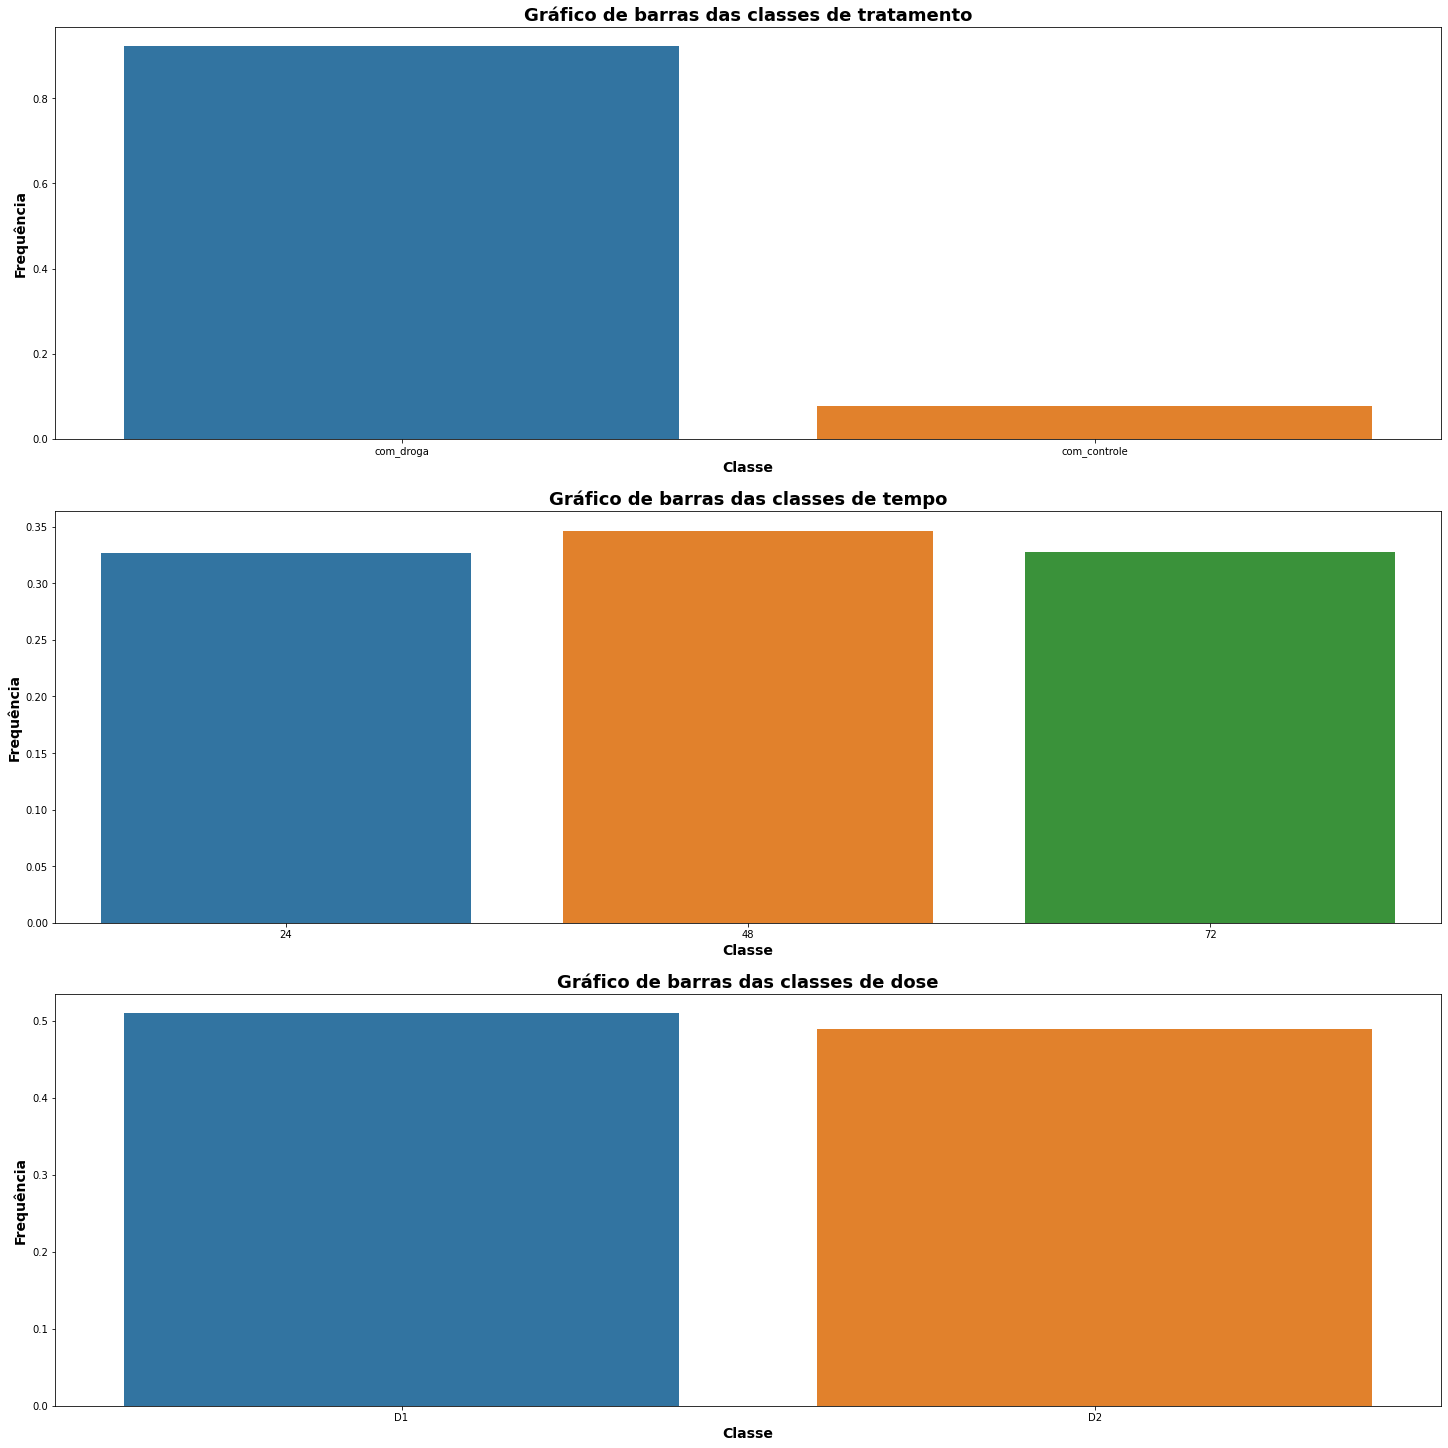

In [21]:
# Essa questão pode ser respondida olhando para os gráficos de barra dos dados de experimento.

# Vamos criar as figuras e atribuir um título
fig, ax = plt.subplots(3,1, figsize=(20,20), constrained_layout=True)


# Criando o gráfico de barras do tratamento
sns.barplot(ax = ax[0], 
            x = dados_experimentos.tratamento.value_counts().index,
            y = dados_experimentos.tratamento.value_counts(normalize=True).values)
ax[0].set_title("Gráfico de barras das classes de tratamento", fontsize = 18, weight = "bold")
ax[0].set_xlabel("Classe", fontsize = 14, weight = "bold")
ax[0].set_ylabel("Frequência", fontsize = 14, weight = "bold")

# Criando o gráfico de barras do tempo
sns.barplot(ax = ax[1], 
            x = dados_experimentos.tempo.value_counts().index,
            y = dados_experimentos.tempo.value_counts(normalize=True).values)
ax[1].set_title("Gráfico de barras das classes de tempo", fontsize = 18, weight = "bold")
ax[1].set_xlabel("Classe", fontsize = 14, weight = "bold")
ax[1].set_ylabel("Frequência", fontsize = 14, weight = "bold")

# Criando o gráfico de barras da dose
sns.barplot(ax = ax[2], 
            x = dados_experimentos.dose.value_counts().index,
            y = dados_experimentos.dose.value_counts(normalize=True).values)
ax[2].set_title("Gráfico de barras das classes de dose", fontsize = 18, weight = "bold")
ax[2].set_xlabel("Classe", fontsize = 14, weight = "bold")
ax[2].set_ylabel("Frequência", fontsize = 14, weight = "bold")




#### **Conclusões**

Nota-se um claro desbalanceamento das classes de tratamento (com e sem droga). Isso porque há muitos tipos de drogas testadas em diversas condições de tempo e dosagem, o que leva a uma classe muito maior que a de controle. Todavia, o resto das colunas apresentou dados balanceados. Seria interessante ver se há uma distribuição homogênea das drogas (isto é, se cada um dos compostos foi testado em um mesmo número de vezes, ou se alguns foram mais testados do que outros).

### **Pergunta 2**: equilibrio de compostos.

*O número de testes de cada composto é igual ou próximo?*

In [22]:
# Podemos começar olhando para a contagem de experimentação de cada composto
# Nota-se maior presença do "composto" cacb2b860 é o do grupo de controle (isto é, não se trata de composto) 
# Além disso, algumas drogas parecem mais presentes nos experimentos do que outras
dados_experimentos.droga.value_counts()

cacb2b860    1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
             ... 
b472193a9       1
37a8319f4       1
23d6790ad       1
81a463c0a       1
5cc5a5a19       1
Name: droga, Length: 3289, dtype: int64

In [23]:
#Podemos olhar também para as primeiras vinte observações.
#Como se pode notar, há um desbalanceamento no uso de compostos para experimentos.

dados_experimentos.droga.value_counts().head(20)

cacb2b860    1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
d08af5d4b     196
292ab2c28     194
d50f18348     186
d1b47f29d     178
67c879e79      19
52d1e6f43      18
d488d031d      18
83a9ea167      18
5d9bb0ebe      14
30aa2f709      14
a7c2673c1      14
6b8b675cc      14
11f66c124      14
1a52478dc      14
e0cd5c091      13
Name: droga, dtype: int64

#### **Conclusões**

Há um desbalanceamento também na quantidade de drogas. É importante ter isso em conta no treinamento do modelo de aprendizado de máquinas para que ele não valorize em demasia os compostos claramente mais presentes para realizar as classificações.

### **Pergunta 3**: correlações entre genes (e entre células).

*Existe correlação entre as expressões genéticas (e entre a viabilidade celular)?*

A existência de correlações pode nos indicar se é interessante uma possível redução de dimensionalidade. Isso significa transformar nossos dados em uma forma mais simples que traga informações relevantes. Com isso podemos diminuir a quantidade de ruído (informações irrelevantes, mas que podem prejudicar o funcionamento do modelo de aprendizado de máquina). 



Text(159.0, 0.5, 'Células')

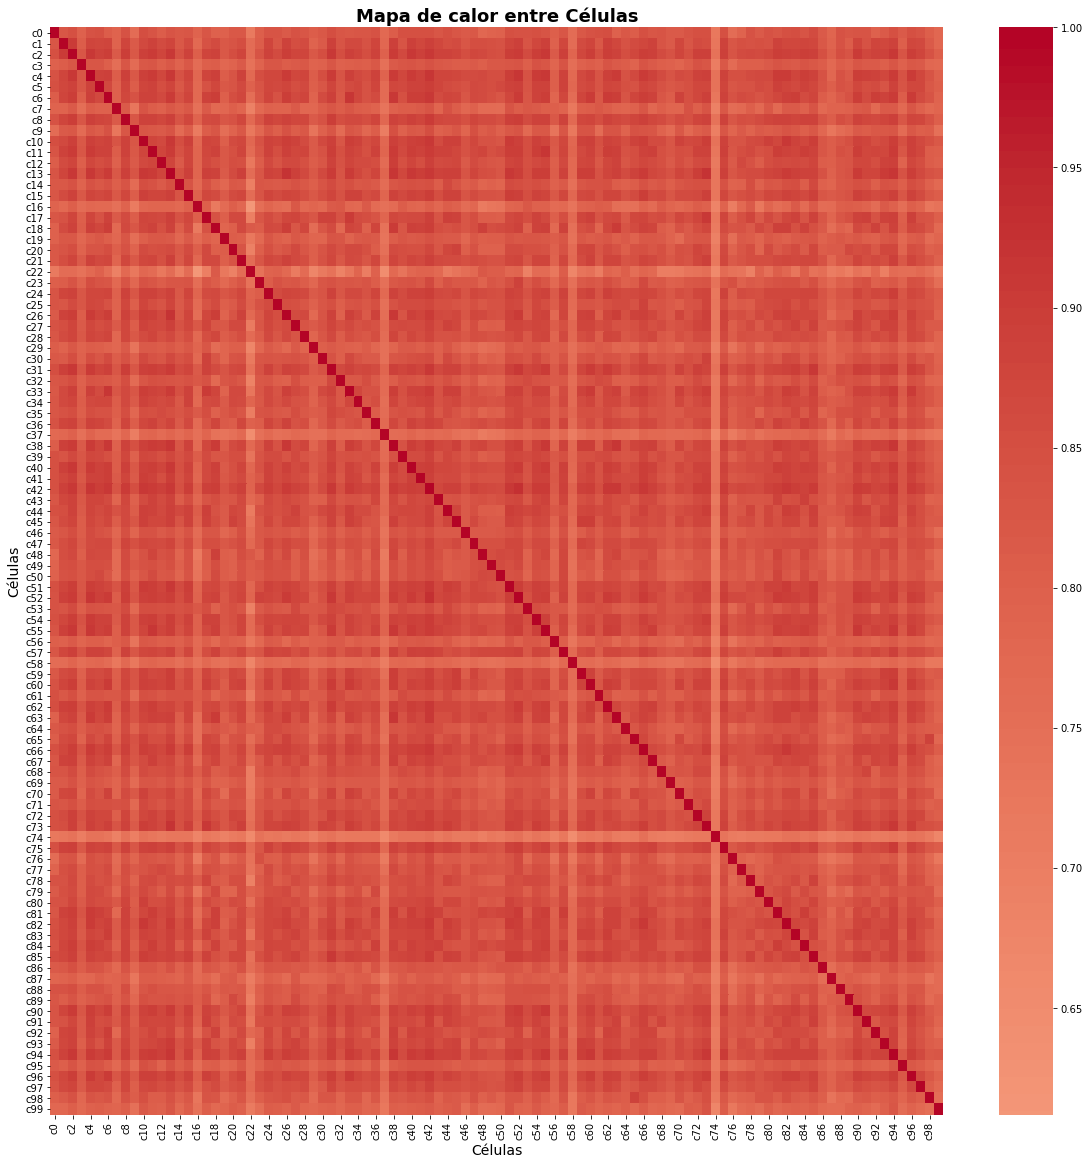

In [24]:
# Podemos ver a correlação entre células usando um mapa de calor.

plt.figure(figsize = (20,20))
sns.heatmap(dados_experimentos.loc[:,"c0":"c99"].corr(), 
            cmap = "coolwarm", 
            center = 0.2)

plt.title("Mapa de calor entre Células", fontsize = 18, weight = "bold")
plt.xlabel("Células", fontsize = 14)
plt.ylabel("Células", fontsize = 14)

Text(159.0, 0.5, 'Genes')

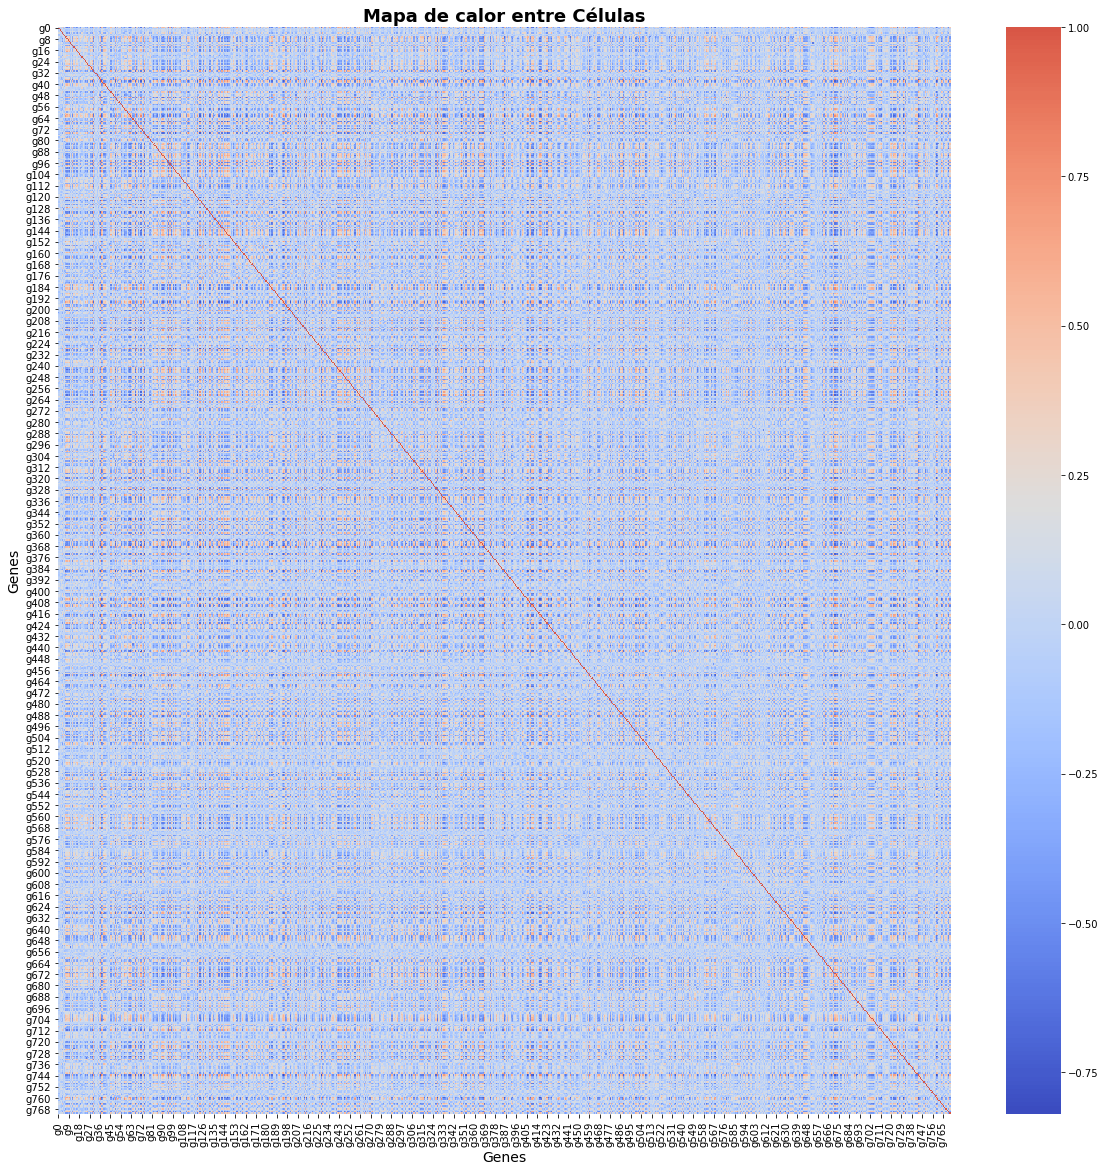

In [25]:
# Repetimos o procedimento para os genes
plt.figure(figsize = (20,20))
sns.heatmap(dados_experimentos.loc[:,"g0":"g771"].corr(),
            cmap = "coolwarm",
            center = 0.2)

plt.title("Mapa de calor entre Células", fontsize = 18, weight = "bold")
plt.xlabel("Genes", fontsize = 14)
plt.ylabel("Genes", fontsize = 14)

#### **Conclusões** 

Avaliando os dois mapas de calor nota-se uma forte correlação da sobrevivência celular entre os vários tipos de células, mas menos em relação as atividades genéticas. Antes de se decidir sobre uma possível redução de dimensionalidade, é interessante observar também a correlação entre genes e células.

### **Pergunta 4**: correlação genes e células 

*Alguns genes tem maior correlação com a sobrevivência celular? Isto é, uma maior(ou menor) atividade genética leva a uma maior (ou menor) sobrevivência celular.*

Essa questão também tem por objetivo auxiliar na possível simplificação dos dados. Na medida em que as atividades de alguns genes apresentam grande correlação com a sobrevivência celular, pode-se fazer transformações que tragam informações relevantes em menor quantidade.

Aqui é interessante olhar e maneira mais detalhada para as correlações. Por isso utilizou-se inicialmente as primeiras quinze colunas de genes e células.

Text(87.0, 0.5, 'Células')

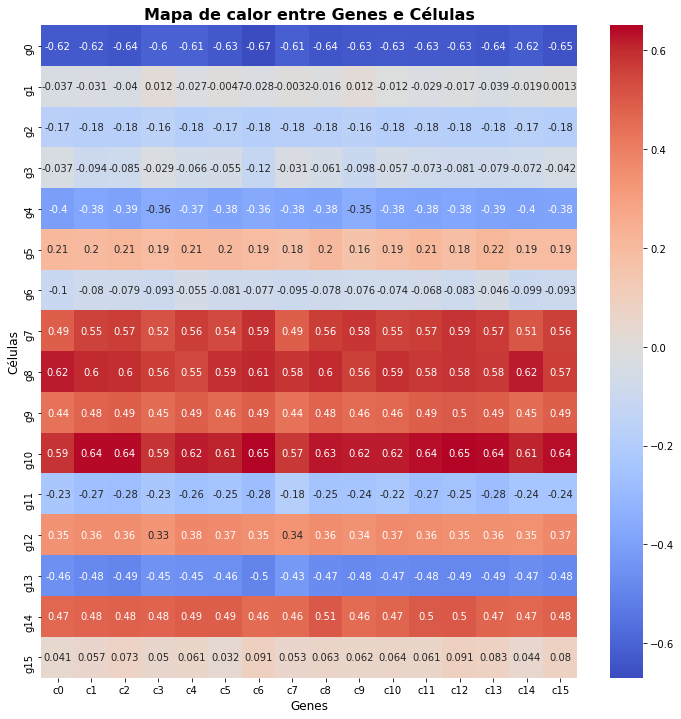

In [26]:
# Podemos verificar a correlação entre expressão genética e sobrevivência celular vai mapa de calor.

# Vamos criar primeiro uma matriz de confusão
matriz_confusão_CG = dados_experimentos.corr().loc["g0":"g15","c0":"c15"]
matriz_confusão_CG

# Podemos criar um mapa de calor.

plt.figure(figsize = (12,12))
sns.heatmap(data = matriz_confusão_CG, 
            annot = True,
            cmap = "coolwarm")
plt.title("Mapa de calor entre Genes e Células", fontsize = 16, weight = "bold")
plt.xlabel("Genes", fontsize = 12)
plt.ylabel("Células", fontsize = 12)

Text(123.0, 0.5, 'Células')

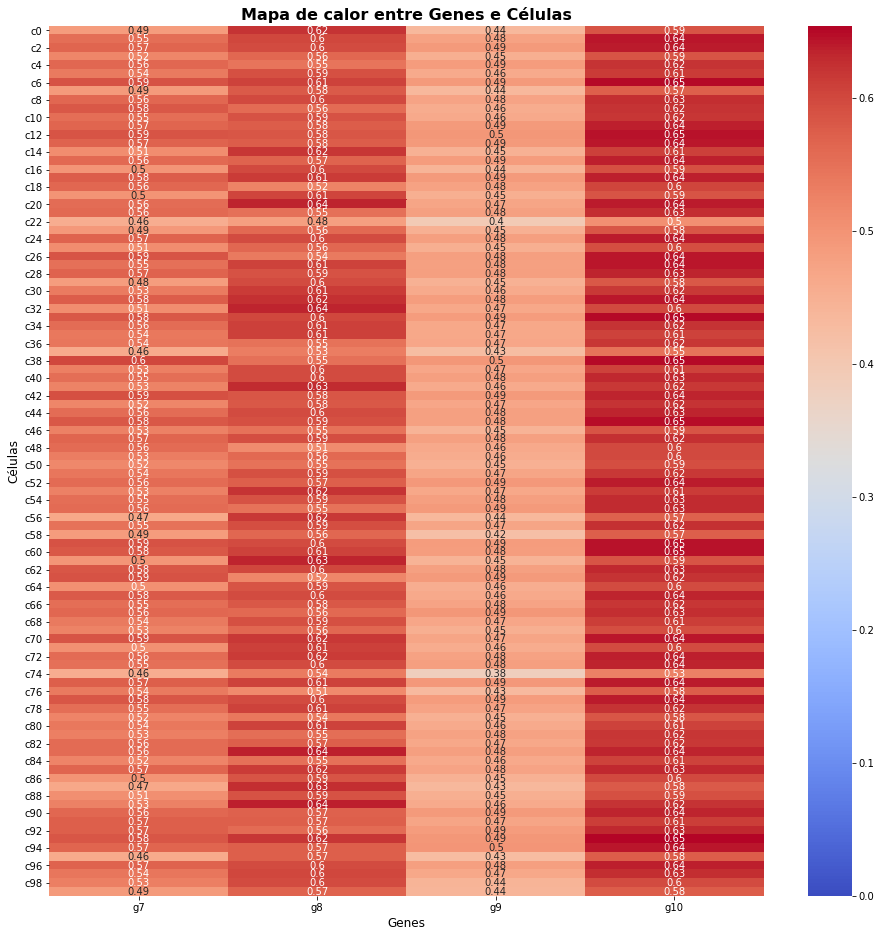

In [27]:
# Considerando os genes com maior correlação, vamos ver seus resultados para todas as células.
# Repetindo o procedimento.
matriz_confusão_CG = dados_experimentos.corr().loc["g7":"g10","c0":"c99"]
matriz_confusão_CG

plt.figure(figsize = (16,16))
sns.heatmap(data = matriz_confusão_CG.T, 
            annot = True,
            cmap = "coolwarm",
            vmin = 0)
plt.title("Mapa de calor entre Genes e Células", fontsize = 16,weight = "bold")
plt.xlabel("Genes", fontsize = 12)
plt.ylabel("Células", fontsize = 12)


#### **Conclusões**

Ao analisar os gráficos de calor, nota-se que existe uma maior correlação entre expressão de alguns genes e sobrevivência celular. Interessante também que essa correlação é relativamente constante entre genes e células (isto é, a manifestação de um gene aumenta ou diminui as chances de sobrevivência de todas as células de maneira aproximadamente igual). Isso indica que pode não ser necessário manter uma base de dados tão grande, mas ainda assim é necessário mais exploração antes de se decidir.

### **Pergunta 5**: compostos desbalanceados.

*Quais são os compostos mais ativados?*

O objetivo aqui é verificar se há um possível desbalanceamento entre os tipos de compostos (que pode afetar os resultados do modelo). 

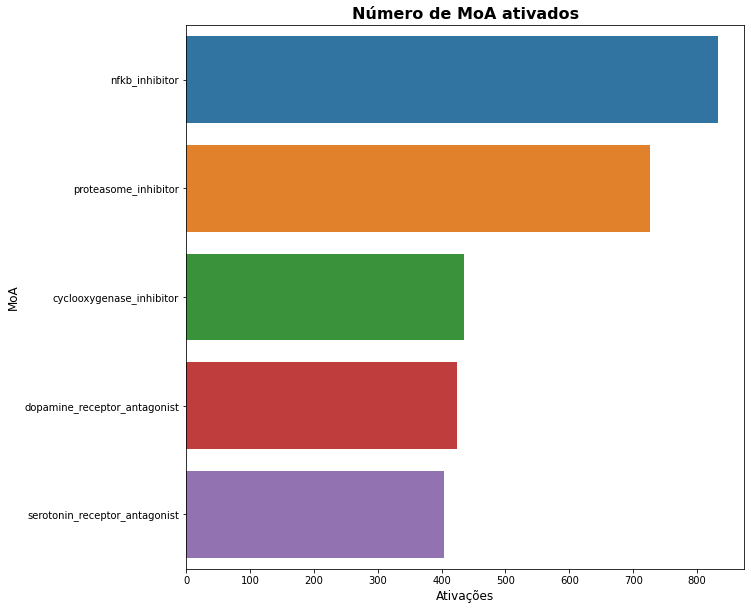

In [28]:
# Podemos visualizar isso com um gráfico de barras do seaborn

plt.figure(figsize= (10,10))

ax = sns.barplot(y = dados_resultados.iloc[:,1:-1].sum(axis=0).sort_values(ascending = False).head(5).index,
            x = dados_resultados.iloc[:,1:-1].sum(axis=0).sort_values(ascending = False).head(5).values)
plt.title("Número de MoA ativados", fontsize = 16, weight = "bold")
plt.xlabel("Ativações", fontsize = 12)
plt.ylabel("MoA", fontsize = 12)

ax.grid(False)

#### **Conclusões**

Nota-se novamente um desbalanceamento dos dados, no caso, dos MoA ativados (interessante que os inibidores são os principais MoA, seguindos dos antagonistas). Isso deve ser considerado na hora de treinar o modelo de Machine Learning.

### **Conclusões gerais das perguntas**

Sintetizando até aqui: analisamos os dados em busca de verificar a existência de possíveis desbalanceamentos e correlações. Quanto aos desequilibrios entre classes, nota-se que as classes de tratamento (com e sem droga) estão desbalanceadas e que o "composto" de controle se apresentou em maior quantidade; há também outro desbalanceamento em relação a quantidade de Mecanismos de Ação (com maior presença de mecanismos do tipo inibidor). Em relação às correlações, verificou-se fortes correlações entre manifestações genéticas e enter esta com viabilidade das células (todavia, não se verificou correlações fortes entre as células).

Com isso podemos definir os próximos passos. Primeiro, será feita uma redução de dimensionalidade (dada a existência das correlações) das colunas genes e células dos dados de experimento; com isso esperamos poder reduzir complexidade dos dados (permitindo o modelo "rodar mais rápido") sem perder muita informação relevante. Segundo, o modelo será treinado tendo em vista desbalanceamento das categorias de MoA. 

## **Redução de Dimensionalidade: PCA**

O objetivo dessa parte é realizar o procedimento de formatação, separação e redução dos dados. Com isso, será possível oferecer dados que poderão ser utilizados pelo aprendizado de máquinas para fins de previsão. 


### **Transformação das colunas tratamento e dose em valores numéricos.**

Antes de normalizar precisamos transformar as colunas tratamento e dose para formato numérico. Uma outra mudança antes necessária é modificar a coluna tempo: Nesta os valores 24, 48 e 72 horas serão representados por 0, 0.5 e 1 respectivamente.


In [29]:
# Transformando a coluna tratamento em dummies.
dados_completos.tratamento = pd.get_dummies(dados_completos.tratamento)

# Vamos ver os resultados.
# Podemos notar que os valores 0 e 1 representam "com_droga" e "com_controle" respectivamente.
dados_completos

,id,tratamento,tempo,dose,droga,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,24,D2,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397,-0.9260,-0.2424,-0.6686,0.2326,0.6456,0.0136,-0.5141,-0.6320,0.7166,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,24,D2,ecf3b6b74,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,0.5112,0.6727,-0.1851,2.8650,-0.2140,-0.6153,0.8362,0.5584,-0.2589,0.1292,0.0148,0.0949,-0.2182,-0.9235,0.0749,-1.5910,-0.8359,-0.9217,0.3013,0.1716,0.0880,0.1842,0.1835,0.543

In [30]:
#Vamos repetir o mesmo procedimento para a coluna dose.
dados_completos.dose = pd.get_dummies(dados_completos.dose)

# O pandas vais transformar nossos dados para os valores 0 e 1, representando D1 e D2 respectivamente.
dados_completos["dose"].replace([0,1],[1,0], inplace = True)
#Vendo os resultados.
dados_completos

,id,tratamento,tempo,dose,droga,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,24,0,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,72,0,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,48,0,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,48,0,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,72,1,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,24,1,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397,-0.9260,-0.2424,-0.6686,0.2326,0.6456,0.0136,-0.5141,-0.6320,0.7166,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,24,1,ecf3b6b74,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,0.5112,0.6727,-0.1851,2.8650,-0.2140,-0.6153,0.8362,0.5584,-0.2589,0.1292,0.0148,0.0949,-0.2182,-0.9235,0.0749,-1.5910,-0.8359,-0.9217,0.3013,0.1716,0.0880,0.1842,0.1835,0.5436,-0.05

In [31]:
dados_completos.iloc[:,871:]

,c94,c95,c96,c97,c98,c99,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23810,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23811,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23812,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Separação dos dados**

Aqui será feita a separação dos dados em três colunas: treino, validação e teste. O objetivo é garantir que os dados de treino e validação não contaminem os dados de teste (que servem para ver a eficiência do modelo quando confrontado com dados novos). Além disso, os dados de treinamento servem de padrão para transformar os demais.


In [32]:
#Separando os dados em x(entrada) e y(saída), é necessário remover a coluna droga também.
x = dados_completos.loc[:, "id":"c99"]
x = x.drop("droga", axis = 1)
y = dados_completos.loc[:, "5-alpha_reductase_inhibitor":]

# Vamos separar os dados (usamos o random_state para garantir que a separação seja sempre a mesma com esses dados).

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = .2, random_state = 10)
x_treino, x_val, y_treino, y_val = train_test_split(x_treino,y_treino, test_size = .2, random_state = 10)

In [33]:
x_treino

,id,tratamento,tempo,dose,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,g35,...,c60,c61,c62,c63,c64,c65,c66,c67,c68,c69,c70,c71,c72,c73,c74,c75,c76,c77,c78,c79,c80,c81,c82,c83,c84,c85,c86,c87,c88,c89,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99
9302,id_63cbe3df6,0,72,1,-0.4089,0.4717,-1.0560,0.4998,0.3704,0.0092,0.4873,0.7167,0.6780,0.1704,0.4558,-0.8565,-0.0492,0.3397,-0.7185,-0.1670,1.3550,0.4733,-0.2121,0.8816,-0.0129,0.5296,-0.0331,1.0320,-0.6505,-0.7492,-1.3970,-0.4338,-0.2825,-0.8486,0.2058,-1.6270,0.7692,-0.2103,-0.4622,0.2751,...,0.5405,0.3741,0.9220,0.5254,0.4819,-0.2768,-0.3665,0.1826,-0.9609,-0.3274,0.0367,0.7079,-0.2176,-0.4314,0.1014,0.2646,-0.3969,-0.6350,0.3858,0.6807,-0.0371,-0.3914,1.4250,0.1574,0.5026,0.7900,0.7857,-0.9292,0.2241,0.6309,1.4910,-0.5493,0.0029,0.0340,0.3979,-0.3415,0.3081,-0.3286,-0.0418,0.1151
3834,id_290dc170a,0,48,0,0.5483,0.2237,0.7596,-0.1851,-0.2069,-0.6576,0.4660,0.3555,-0.3788,-0.2654,0.4927,-0.3313,5.4250,-1.2560,0.5860,-1.0050,-0.2707,-0.5110,0.0000,0.2962,-0.1729,0.5356,0.9774,-0.7355,0.9353,0.1641,-0.1677,-0.7212,0.3096,-0.3444,-0.3912,-0.0813,-0.4071,-1.2480,0.5258,0.7303,...,-1.3220,-0.6019,0.6451,0.2528,0.2775,-1.3040,0.0688,0.3574,0.1754,-0.9847,-0.1751,-0.4958,0.7079,0.5246,-0.2618,-0.6331,-0.2422,0.0140,0.1369,-0.2331,0.9635,-0.2818,-0.5282,0.0607,-0.9727,-0.2960,0.9960,-0.3567,-0.5035,0.3283,0.4792,-0.2776,-0.6075,-0.7198,0.5675,1.5510,-0.2658,-0.4554,0.5676,-0.5303
22097,id_ed0e6ca8d,0,48,1,-0.2892,-1.7200,-0.0372,-2.9240,0.8065,1.8480,-0.0331,-1.2020,-0.3424,-0.2974,-0.2831,-3.2000,-1.0770,-0.3511,-0.8407,0.6468,0.2577,-0.1613,0.0813,1.0610,-1.7210,0.1052,1.0280,0.4182,-1.1370,-1.2820,-2.1110,-1.9480,0.6658,1.0400,-1.4240,0.0950,-1.7750,1.3840,-2.5870,1.2690,...,-1.8610,-0.6868,-0.9278,-5.6260,-3.7090,-3.1310,-2.0180,-2.1730,-0.2538,-0.8269,-1.1460,-2.3410,-1.3880,-2.8860,-1.5860,-2.5020,-2.0280,0.0257,-1.6500,-3.6780,-1.9030,-2.1370,-2.6850,-1.6290,-2.2510,-1.5420,-0.5397,-0.7593,-1.9030,-1.3980,-3.3750,-3.5130,-2.2360,-0.8857,-3.2410,-3.9150,-1.2840,-0.6020,-4.3930,-2.1590
17827,id_bf6c0bbad,0,48,0,-0.5906,-0.0303,-0.1080,0.3606,-0.8293,0.1373,-0.4290,-0.0956,0.5347,0.2602,1.2180,0.7138,0.1163,1.3560,1.2290,-0.1084,0.3340,-0.3210,0.7463,0.1491,0.1547,-1.3240,0.4485,0.3372,-0.2015,0.1051,1.1270,0.2173,0.7411,-0.1586,0.1058,-0.0540,-1.4930,-0.3480,0.0817,0.2230,...,-0.3829,0.8593,0.1712,0.4671,0.1341,1.2320,0.1227,-0.1454,0.6081,-0.4462,-0.5713,0.6553,0.8920,0.6947,0.3976,0.2959,0.8413,0.8202,0.0066,0.0567,0.8612,-0.3595,0.4227,0.9224,-0.3012,0.6602,-0.7645,-0.0146,0.1815,-0.6236,0.6397,0.5720,0.2777,-0.6963,0.1593,0.4182,1.5000,-0.1188,0.8112,0.6445
10122,id_6cf9496a4,0,24,1,-1.0210,-0.6002,1.0960,-0.2831,-0.9709,0.6952,-0.2169,-0.8813,-0.6552,1.0740,-0.5474,0.5012,-1.0090,-0.0672,0.0532,1.7040,2.2770,-1.1960,0.5299,0.8489,0.4216,-1.6070,-0.6789,-0.0960,-0.8002,0.4997,0.3629,-0.9041,0.3092,1.8600,0.7850,0.2536,-1.3260,0.1619,1.0920,-0.9594,...,-0.6808,0.5709,0.5665,0.3421,0.0240,0.5115,0.7938,0.8849,-0.5169,0.5015,-1.0760,0.0146,0.4816,-0.5460,0.3719,-0.4332,-0.5154,0.4591,-0.0336,-0.3919,0.3437,0.2900,-0.1261,0.3373,-0.2291,0.8919,-0.5482,-0.2126,0.5918,-0.7064,-0.2685,-0.7540,0.4285,0.6115,-0.1826,-0.9626,0.1204,-0.1168,0.4520,0.1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8585,id_5c7a74a75,1,72,1,-1.3550,0.8956,0.5569,-0.5329,-1.0400,-1.1660,-1.8510,-0.2952,0.8717,0.4724,1.2530,0.6035,0.8294,0.8777,1.7250,0.2836,-0.5016,0.5197,0.0594,-0.2216,0.2105,-1.7770,0.8515,0.1374,1.1730,0.2370,0.6939,0.1214,0.5706,-1.3000,0.7569,0.3824,-0.6804,0.4272,0.3683,0.3371,...,0.9191,-0.2277,0.8172,0.3152,0.5547,0.9685,0.7771,0.

### **Normalização**
Antes de realizar a transformação dos dados, é necessário normalizar estes. Isso porque a escala deles pode afetar a criação dos componentes princiais. Com a normalização os dados vão ficar em uma escala de 0 e 1. 

A normalização funciona extraindo de cada dado (X) o valor mínimo encontrado na sua coluna (Xmin) e dividide pela subtração do valor máximo pelo mínimo(Xmax - Xmin). Isto é:

$\ {X}_{normalizado} = \frac{{X}_{i} - {X}_{min}}{{X}_{max} - {X}_{min}} $ 

Uma mudança a parte deve ser feita na coluna tempo. Nesta os valores 24, 48 e 72 horas serão representados por 0, 0.5 e 1 respectivamente.


In [34]:
# Chamamos a função de normalização.
normalização = MinMaxScaler()

#Colocamos os valores de treino para normalizar. 
normalização.fit(x_treino.drop(["id"], axis = 1))

# Tranformamos os dados

normalização.transform(x_treino.drop(["id"], axis = 1))
normalização.transform(x_treino.drop(["id"], axis = 1))
normalização.transform(x_treino.drop(["id",], axis = 1))

# Visualizando os resultados
x_treino

,id,tratamento,tempo,dose,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,g35,...,c60,c61,c62,c63,c64,c65,c66,c67,c68,c69,c70,c71,c72,c73,c74,c75,c76,c77,c78,c79,c80,c81,c82,c83,c84,c85,c86,c87,c88,c89,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99
9302,id_63cbe3df6,0,72,1,-0.4089,0.4717,-1.0560,0.4998,0.3704,0.0092,0.4873,0.7167,0.6780,0.1704,0.4558,-0.8565,-0.0492,0.3397,-0.7185,-0.1670,1.3550,0.4733,-0.2121,0.8816,-0.0129,0.5296,-0.0331,1.0320,-0.6505,-0.7492,-1.3970,-0.4338,-0.2825,-0.8486,0.2058,-1.6270,0.7692,-0.2103,-0.4622,0.2751,...,0.5405,0.3741,0.9220,0.5254,0.4819,-0.2768,-0.3665,0.1826,-0.9609,-0.3274,0.0367,0.7079,-0.2176,-0.4314,0.1014,0.2646,-0.3969,-0.6350,0.3858,0.6807,-0.0371,-0.3914,1.4250,0.1574,0.5026,0.7900,0.7857,-0.9292,0.2241,0.6309,1.4910,-0.5493,0.0029,0.0340,0.3979,-0.3415,0.3081,-0.3286,-0.0418,0.1151
3834,id_290dc170a,0,48,0,0.5483,0.2237,0.7596,-0.1851,-0.2069,-0.6576,0.4660,0.3555,-0.3788,-0.2654,0.4927,-0.3313,5.4250,-1.2560,0.5860,-1.0050,-0.2707,-0.5110,0.0000,0.2962,-0.1729,0.5356,0.9774,-0.7355,0.9353,0.1641,-0.1677,-0.7212,0.3096,-0.3444,-0.3912,-0.0813,-0.4071,-1.2480,0.5258,0.7303,...,-1.3220,-0.6019,0.6451,0.2528,0.2775,-1.3040,0.0688,0.3574,0.1754,-0.9847,-0.1751,-0.4958,0.7079,0.5246,-0.2618,-0.6331,-0.2422,0.0140,0.1369,-0.2331,0.9635,-0.2818,-0.5282,0.0607,-0.9727,-0.2960,0.9960,-0.3567,-0.5035,0.3283,0.4792,-0.2776,-0.6075,-0.7198,0.5675,1.5510,-0.2658,-0.4554,0.5676,-0.5303
22097,id_ed0e6ca8d,0,48,1,-0.2892,-1.7200,-0.0372,-2.9240,0.8065,1.8480,-0.0331,-1.2020,-0.3424,-0.2974,-0.2831,-3.2000,-1.0770,-0.3511,-0.8407,0.6468,0.2577,-0.1613,0.0813,1.0610,-1.7210,0.1052,1.0280,0.4182,-1.1370,-1.2820,-2.1110,-1.9480,0.6658,1.0400,-1.4240,0.0950,-1.7750,1.3840,-2.5870,1.2690,...,-1.8610,-0.6868,-0.9278,-5.6260,-3.7090,-3.1310,-2.0180,-2.1730,-0.2538,-0.8269,-1.1460,-2.3410,-1.3880,-2.8860,-1.5860,-2.5020,-2.0280,0.0257,-1.6500,-3.6780,-1.9030,-2.1370,-2.6850,-1.6290,-2.2510,-1.5420,-0.5397,-0.7593,-1.9030,-1.3980,-3.3750,-3.5130,-2.2360,-0.8857,-3.2410,-3.9150,-1.2840,-0.6020,-4.3930,-2.1590
17827,id_bf6c0bbad,0,48,0,-0.5906,-0.0303,-0.1080,0.3606,-0.8293,0.1373,-0.4290,-0.0956,0.5347,0.2602,1.2180,0.7138,0.1163,1.3560,1.2290,-0.1084,0.3340,-0.3210,0.7463,0.1491,0.1547,-1.3240,0.4485,0.3372,-0.2015,0.1051,1.1270,0.2173,0.7411,-0.1586,0.1058,-0.0540,-1.4930,-0.3480,0.0817,0.2230,...,-0.3829,0.8593,0.1712,0.4671,0.1341,1.2320,0.1227,-0.1454,0.6081,-0.4462,-0.5713,0.6553,0.8920,0.6947,0.3976,0.2959,0.8413,0.8202,0.0066,0.0567,0.8612,-0.3595,0.4227,0.9224,-0.3012,0.6602,-0.7645,-0.0146,0.1815,-0.6236,0.6397,0.5720,0.2777,-0.6963,0.1593,0.4182,1.5000,-0.1188,0.8112,0.6445
10122,id_6cf9496a4,0,24,1,-1.0210,-0.6002,1.0960,-0.2831,-0.9709,0.6952,-0.2169,-0.8813,-0.6552,1.0740,-0.5474,0.5012,-1.0090,-0.0672,0.0532,1.7040,2.2770,-1.1960,0.5299,0.8489,0.4216,-1.6070,-0.6789,-0.0960,-0.8002,0.4997,0.3629,-0.9041,0.3092,1.8600,0.7850,0.2536,-1.3260,0.1619,1.0920,-0.9594,...,-0.6808,0.5709,0.5665,0.3421,0.0240,0.5115,0.7938,0.8849,-0.5169,0.5015,-1.0760,0.0146,0.4816,-0.5460,0.3719,-0.4332,-0.5154,0.4591,-0.0336,-0.3919,0.3437,0.2900,-0.1261,0.3373,-0.2291,0.8919,-0.5482,-0.2126,0.5918,-0.7064,-0.2685,-0.7540,0.4285,0.6115,-0.1826,-0.9626,0.1204,-0.1168,0.4520,0.1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8585,id_5c7a74a75,1,72,1,-1.3550,0.8956,0.5569,-0.5329,-1.0400,-1.1660,-1.8510,-0.2952,0.8717,0.4724,1.2530,0.6035,0.8294,0.8777,1.7250,0.2836,-0.5016,0.5197,0.0594,-0.2216,0.2105,-1.7770,0.8515,0.1374,1.1730,0.2370,0.6939,0.1214,0.5706,-1.3000,0.7569,0.3824,-0.6804,0.4272,0.3683,0.3371,...,0.9191,-0.2277,0.8172,0.3152,0.5547,0.9685,0.7771,0.

### **Redução de dimensionalidade**

O objetivo dessa seção é transformar nossos dados de experimentos em menos colunas usando da Análise de Componentes Principais (Principal Componentes Analysis ou PCA). O PCA é explicado por Bruce e Bruce (2019, p. 259): 


> "A ideia de PCA é combinar múltiplas variáveis preditoras numéricas em um conjunto menor de variáveis, que são combinações lineares ponderadas do conjunto original. O menor conteudo de variáveis, os *componentes principais*, 'explica' a maior parte da variabilidade do conjunto completo de variáveis, reduzindo a dimensão dos dados."

Em resumo, PCA é uma técnica estatística para diminuir a complexidade dos dados, mas preservando o máximo de informação importante. Com isso podemos obter um modelo com menos ruido, que não demore em demasia para ser treinado e testado (o que seria inviável se ele utilizasse todos os dados disponíveis) e que possa fazer previsões melhores que o modelo "burro".  

In [35]:
# Vamos tentar reduzir de mais 800 colunas para 100 e ver a variância explicada
pca = PCA(n_components = 50, random_state= 2)

# Precisamos ajustar os dados de treino ao PCA
pca.fit(x_treino.drop("id", axis = 1))

# Vamos ver o quanto da variância observada o PCA explica.
pca.explained_variance_ratio_.sum()

0.766341107465992

Text(0, 0.5, 'Variância explicada')

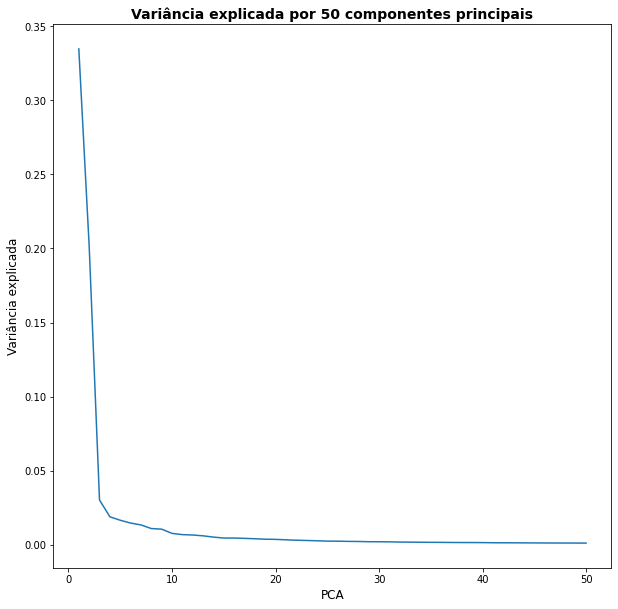

In [36]:
# Podemos visualizar também a variância explicada em um gráfico de linha.

plt.figure(figsize = (10,10))
sns.lineplot(x = range(1,51), y = pca.explained_variance_ratio_)
plt.title("Variância explicada por 50 componentes principais", fontsize = 14, weight = "bold")
plt.xlabel("PCA", fontsize = 12)
plt.ylabel("Variância explicada", fontsize = 12)

In [37]:
# Precisamos transformar os nossos dados antes de treinar e testar o modelo.
# Começando pelo dados de treino
pca_xtreino = pca.transform(x_treino.drop("id", axis = 1))
x_treino = x_treino.filter(["id"])
x_treino = pd.concat([x_treino, pd.DataFrame(pca_xtreino, index = x_treino.index)], axis = 1, ignore_index= False)

# Passando para os dados de validação
pca_xval = pca.transform(x_val.drop("id", axis = 1))
x_val = x_val.filter(["id"])
x_val = pd.concat([x_val, pd.DataFrame(pca_xval, index = x_val.index)], axis = 1, ignore_index= False)

# Finalmente chegando nos dados de teste
pca_xteste = pca.transform(x_teste.drop("id", axis = 1))
x_teste = x_teste.filter(["id"])
x_teste = pd.concat([x_teste, pd.DataFrame(pca_xteste, index = x_teste.index)], axis = 1, ignore_index= False)


In [38]:
# Vamos ver os resultados com dados de teste
x_teste

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
8579,id_5c6213d9c,-8.627685,-24.735237,-1.023225,2.060433,-1.803987,2.003435,-2.601205,-0.769768,0.474867,-0.247112,-2.133188,-1.010947,-1.186513,0.099335,-3.125786,-0.850044,0.617265,-0.534695,-2.245514,-2.649292,-1.596031,1.160887,1.055110,0.328691,0.463481,-0.387895,0.685986,-0.496223,-1.090649,-0.401098,0.413644,-0.899231,-0.946718,1.019537,-0.121649,-1.264970,-1.127197,-0.852314,-0.110370,1.298837,-0.648941,-0.730466,0.650088,0.881088,0.126475,1.657220,-0.514449,0.864105,0.125581,-0.777165
16718,id_b3a8254d6,-12.760207,22.824739,1.073688,-3.849186,-6.431928,-1.562286,-1.928198,-1.582774,0.434892,3.105604,0.047031,0.168586,-0.132740,1.126881,-3.597611,1.894245,1.208800,-1.462374,-0.751957,0.282972,-3.283959,-0.581591,-0.355497,1.553509,-1.453737,0.934024,1.729354,-4.592183,-0.745692,0.887119,-2.431397,-0.145083,-2.195615,2.347300,0.946285,-0.633049,0.782281,1.327557,-1.511132,2.252245,2.293591,-2.133829,-0.391886,0.242301,0.499460,-3.028880,-1.782338,-0.920605,2.063885,-0.695361
17007,id_b7134c696,-4.483092,-24.507188,0.274992,1.894665,-1.066841,0.025993,0.520984,-2.913340,2.911755,-0.463815,0.685288,-2.062282,-1.950888,0.075966,-1.273376,0.541485,-0.071173,0.302515,0.331905,-0.793581,1.755555,-0.965878,0.568578,0.659453,2.754108,-1.130523,-0.510055,-1.115999,0.147897,1.135686,-0.228715,0.402550,1.500556,-1.127947,1.037903,-0.008409,0.061614,-1.117738,-0.164388,0.808336,-1.211384,-1.117847,0.493217,-0.164802,0.471702,-0.114532,-0.247284,-0.175770,-1.948574,-1.400985
1901,id_14957ed5e,-10.923376,22.993811,3.556720,3.569968,3.378224,1.152087,2.947826,0.632410,1.690326,-0.226355,-0.968188,-0.948784,-3.837170,0.747339,-0.394443,-0.402673,-0.576305,-0.517627,1.483806,-0.979613,0.855079,0.185323,1.255377,0.248044,1.239966,-1.879332,-0.074140,-2.051918,0.205710,-0.435272,-1.921645,-0.189925,0.058166,-0.398704,-0.138312,-2.433996,-1.046154,0.206487,-1.785966,-0.464024,0.686119,-0.978934,-1.885510,0.095595,-0.024340,1.009175,-1.204121,-1.104667,1.376847,-0.652185
13470,id_9133110c1,-1.146702,24.634975,-4.160068,-1.337252,9.326633,1.198119,-6.297764,6.209220,-6.909051,-1.717246,-0.862794,-0.406791,-5.405967,-2.966304,0.957549,-6.888818,0.866373,-1.665053,2.028000,-0.412369,2.278879,-3.410213,1.677454,-1.830964,-3.393020,1.120181,2.661695,-2.350279,3.536912,1.957810,-2.039203,-6.801898,1.039437,-2.143083,-1.225703,2.290363,-3.193768,3.046708,-1.323891,2.095445,-2.604171,-1.419966,0.037173,0.349472,2.853056,-4.104354,1.309581,1.660784,1.717225,-1.358679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16921,id_b6021fa6c,-9.764154,22.993606,5.355298,4.086357,5.082210,0.390900,4.177796,4.294438,0.357220,-1.794919,0.352296,1.143026,-2.836785,-0.850047,-1.337575,-0.129711,-0.392247,-0.566886,-2.402400,-0.811971,-0.253770,0.489541,-0.922405,-0.346266,-0.927241,-0.911828,-0.086638,1.113015,-0.247041,0.478131,1.158815,-2.514430,-0.579386,1.109466,2.087862,-0.725988,-0.790895,-0.527165,-1.715708,-1.527424,2.425994,-0.546775,-0.215842,-1.793270,-1.182659,0.304512,-0.401680,0.160673,-1.441605,0.674043
1166,id_0bfa8a6f1,-9.532467,-0.857754,1.416644,-0.480454,1.415786,-0.164604,-0.721458,0.575829,2.000314,0.419827,1.527572,-2.651060,1.187465,-2.753155,0.544163,-1.340127,0.099889,1.238639,-0.729177,-2.331888,1.943990,-0.332948,-1.374588,5.761619,-2.196928,1.138731,0.238973,2.791128,0.871464,-1.946838,0.567493,2.353957,2.883210,-2.024241,-0.037142,-0.791752,-2.207526,0.472073,-0.700533,2.076507,0.113874,-0.913539,3.360637,-0.787938,0.191472,0.064494,-0.528109,-1.763974,-1.223647,1.550281
11794,id_7f099b320,-8.640554,-0.940121,1.049922,-0.202547,0.476383,-0.248308,0.965607,0.719932,1.603499,2.311716,1.651344,-3.044008,-2.114491,-0.702559,-0.312391,-0.8

#### **Resultados**:

Aplicando o PCA foi possível reduzir o número de colunas de treinamento de mais de 877 para apenas 50. Com isso temos uma base de dados menor e que viabiliza, em tempo razoável, o treinamento e teste dos modelos de aprendizado de máquina.

## **Aprendizado de máquina**

Foi feita uma busca dos melhores modelos KNN e Árvore Extra em paralelo usando da função [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Em razão de sua melhor performance em reduzir a perda em Log e também em acurácia, optou-se por escolher a Árvore Extra. Abaixo está o modelos escolhidos, seus "melhores" hiperparâmetros (segundo a avaliação padrão de acurácia), e os resultados.

### **Árvore Extra**

A Árvore Extra é um modelo que tira a média dos resultados de diversas Árvores de Decisão para fazer previsões. Uma Árvore de Decisão é um tipo de modelo estatístico que divide os dados com base em certas regras de decisão. Para mais detalhes recomendo que se veja a documentação das [Árvores de Decisão](https://scikit-learn.org/stable/modules/tree.html) [Árvores Extras](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) do Scikit Learn.  

In [39]:
# Vamos primeiro treinar o modelo
AExtra = AExtra = ExtraTreesClassifier(n_estimators = 10,
                  max_features = 4,
                  min_samples_split = 8).fit(x_treino.drop("id", axis = 1), y_treino)

In [40]:
# Agora vamos ver o tempo que o modelo demora para fazer previsões.
começo = time.time()
y_previsto = AExtra.predict(x_teste.drop("id", axis = 1))
fim = time.time()
tempo_AExtra_teste = fim - começo

In [41]:
y_teste.shape

(4763, 206)

In [42]:
# Vamos ver os resultados.
Acuracia_AExtra = AExtra.score(x_teste.drop("id", axis = 1), y_teste)
print("Acurácia:", Acuracia_AExtra)

Acurácia: 0.456644971656519


In [43]:
# Vamos também ver a perda em Log.
Log_AExtra = log_loss(y_teste, y_previsto)
print("Perda em Log:", Log_AExtra)

Perda em Log: 3.397637033008598


In [44]:
# Finalmente, vejamos o tempo de teste do modelo.
print("Tempo de teste:",tempo_AExtra_teste, "Segundos")

Tempo de teste: 1.2293939590454102 Segundos


### **Comparando com o Modelo Burro**

Um modelo burro é apenas o nome do modelo base que serve de comparação. Ele funciona "chutando" a classe que mais aparece para todas as previsões. A partir de seus resultados, podemos ver o quão melhores (ou piores) são os modelos testados. 

  Se nosso modelo tivessem piores resultados seria necessários os modificar ou, no limite, os abandonar. Por sorte não é esse o caso, na medida em que observa-se melhores resultad da Árvore Extra quando comparada com o modelo dummy.

In [45]:
# Vamos comparar os resultados com um modelo dummy usando a estratégia de "chutar" a classede maior frequência.

modelo_burro = DummyClassifier("most_frequent")
modelo_burro.fit(x_treino.drop("id", axis = 1),y_treino)

Acuracia_burro = modelo_burro.score(x_teste.drop("id", axis = 1),y_teste)
log_burro =  log_loss(y_teste, (modelo_burro.predict(x_teste.drop("id", axis = 1))))

print("Acurácia:", Acuracia_burro)
print("Perda Log:", log_burro)

Acurácia: 0.3995381062355658
Perda Log: 3.7361130387900903


In [46]:
# Podemos comparar os resultados percentualmente.
print("Razão de Acurácia:", Acuracia_AExtra/Acuracia_burro)
print("Razão da Perda Log", log_burro/Log_AExtra)

Razão de Acurácia: 1.1429322122963743
Razão da Perda Log 1.0996210020355743


### **Conclusões**

Observamos que o modelo conseguiu obter pontuações de acurácia próximo a 15% acima do modelo padrão ("burro"). Ainda, conseguiu-se diminuir a perda em log em aproximadamente 10%. Todavia, apesar de tecnicamente o modelo ser um sucesso, isso não necessariamente significa que ele possa ser utilizado para fins de aplicações práticas (isto é, para auxiliar na descoberta de compostos com potencial de gerar novas drogas). Apesar de ele poder auxiliar na descoberta de novos compostos de maneira rápida, recomenda-se fortemente que seus resultados e uso sejam acompanhados por um pesquisador especializado.

**Considerações Finais**

Ao invés de se retomar todo o discutido acima, optou-se por fazer algumas ponderações. Por limitações de tempo, não foi possível se explorar a fundo tdos os modelos potencialmente úteis para a tarefa em tela, nem outras formas de se reduzir a complexidade dos dados. Por isso, para se obter algorítimos mais precisos e úteis para aplicações práticas, recomenda-se que futuras pesquisas se utilizem de modelos mais complexos (como Redes Neurais, por exemplo) e também que busquem alternatvias ao PCA para reduzir a complexidade dos dados. Além disso, apesar do potencial dos modelos estatísticos usados no aprendizado de máquina e IA de captar relações entre os dados, é fundamental a presença do pesquisador especializo para se descobrir relações de causalidadecausalidade e em avaliar a qualidade prática dos modelos. 

# **Referências**

BROWNLEE, Jason. *How to Develop an Extra Trees Ensemble with Python*. 22 Abr. 2020. Disponível em:
<https://machinelearningmastery.com/extra-trees-ensemble-with-python/>. Acesso em: 08 Mai. 2021.

BRUCE, Peter; BRUCE, Andrew. *Estatística Prática para Cientista de Dados*. traduzido por Luciana Ferraz. Rio de Janeiro: Alta Books, 2019.

FLEMING, Nic. How artificial intelligence is changing drug discovery. Nature, v. 557, n. 7706, p. S55-S55, 2018. Disponível em: <https://www.nature.com/articles/d41586-018-05267-x>. Acesso em: 06 Mai. 2021.

MULLARD, Asher. The drug-maker's guide to the galaxy. Nature News, v. 549, n. 7673, p. 445, 2017. Disponível em: <https://www.nature.com/news/the-drug-maker-s-guide-to-the-galaxy-1.22683>. Acesso em: 06 Mai. 2021.

ROWE, Sebastian. *Modern Drug Discovery: Why is the drug development pipeline full of expensive failures?*.SITN. 21 Abr. 2020. Disponível em: <https://sitn.hms.harvard.edu/flash/2020/modern-drug-discovery-why-is-the-drug-development-pipeline-full-of-expensive-failures/>. Acesso em 06 Mai. 2021.

WOUTERS, Olivier J.; MCKEE, Martin; LUYTEN, Jeroen. Estimated research and development investment needed to bring a new medicine to market, 2009-2018. *Jama*, v. 323, n. 9, p. 844-853, 2020. Disponível em: <https://jamanetwork.com/journals/jama/fullarticle/2762311>. Acesso em: 06 Mai. 2021.
